<a href="https://colab.research.google.com/github/anushkaa-ambuj/Knowledge-Distillation-of-Chest-X-Ray-Images/blob/main/HKD_Cifar10-Task%202(i).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Teacher: DenseNet 121 <br>
Student: MobileNet

Dataset: CIFAR 10</b>

Teacher Acc = 76
Student Acc =

## Import Dependancies

In [ ]:
!pip install torchinfo

## Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torchinfo
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision.utils import make_grid
#import timer

## Define the device to use

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Data Transformations

Currently, not utilzing any data transformations

In [ ]:
# Define the transforms for data augmentation
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

## Import the Dataset
### Splitting the Dataset

In [ ]:
# Load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True,
                                  download=True, transform=transforms.ToTensor())

test_dataset = datasets.CIFAR10(root='./data', train=False,
                                 download=True, transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:05<00:00, 29497865.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_data, val_data = torch.utils.data.random_split(train_dataset, [40000, 10000])

## Data Loader

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64,
                                          shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                         shuffle=False)

## Teacher Model

### Initializing the Teacher model

In [ ]:
teacher = models.densenet121(pretrained=True)
num_ftrs = teacher.classifier.in_features
print("num_ftrs=",num_ftrs)
teacher.classifier = nn.Linear(num_ftrs, 10) # CIFAR-10 has 10 classes
teacher.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 58.8MB/s]


num_ftrs= 1024


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Teacher Model Summary

In [ ]:
torchinfo.summary(teacher, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
DenseNet                                 [1, 3, 224, 224]          [1, 10]                   --                        --                        --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 1024, 7, 7]           --                        --                        --
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     [7, 7]                    118,013,952
│    └─BatchNorm2d: 2-2                  [1, 64, 112, 112]         [1, 64, 112, 112]         128                       --                        128
│    └─ReLU: 2-3                         [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --                        --
│    └─MaxPool2d: 2-4                    [1, 64, 112, 112]         [1, 64, 56, 56]           --

### Train Teacher Model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [ ]:
epochs = 35

In [ ]:
train_loss = []; train_acc = []
val_loss = []; val_acc = []

for epoch in range(epochs):
    l1 = []; a1 = []
    l2 = []; a2 = []

    #start = timer()
    for i, (img, labels) in enumerate(trainloader):
        img = img.to(device)
        labels = labels.to(device)
        output = teacher(img)

        probs = F.softmax(output,dim=1)
        max_prob,preds = torch.max(probs,dim=1)
        acc = (torch.sum(preds == labels).item() / len(preds))
        a1.append(acc)

        loss = criterion(output, labels)
        l1.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    for img, lbl in valloader:
        img = img.to(device)
        lbl = lbl.to(device)
        output = teacher(img)

        loss = criterion(output,lbl)
        l2.append(loss.item())

        probs = F.softmax(output,dim=1)
        max_prob,preds = torch.max(probs,dim=1)
        acc = (torch.sum(preds == lbl).item() / len(preds))
        a2.append(acc)

    train_loss.append(np.mean(l1))
    val_loss.append(np.mean(l2))
    train_acc.append(np.mean(a1))
    val_acc.append(np.mean(a2))

    #end = timer()
    #time = end - start
    #time = time/60

    print(f'Epoch {epoch+1}: Train Loss==> {np.mean(l1):.2f} Train_Acc==> {np.mean(a1)*100 :.3f} % Val Loss==> {np.mean(l2):.2f}  Val_Acc==> {np.mean(a2)*100 :.3f} %')
    #print(f'Epoch {epoch+1}: Train Loss==> {np.mean(train_loss):.2f} Train_Acc==> {np.mean(train_acc)*100 :.3f} % Val Loss==> {np.mean(val_loss):.2f} Val_Acc==> {np.mean(val_acc)*100 :.3f} % Time==> {time:.2f} mins')

Epoch 1: Train Loss==> 2.12 Train_Acc==> 32.667 % Val Loss==> 2.08  Val_Acc==> 27.737 %
Epoch 2: Train Loss==> 1.91 Train_Acc==> 33.970 % Val Loss==> 1.75  Val_Acc==> 36.704 %
Epoch 3: Train Loss==> 1.57 Train_Acc==> 43.360 % Val Loss==> 1.45  Val_Acc==> 47.661 %
Epoch 4: Train Loss==> 1.39 Train_Acc==> 49.473 % Val Loss==> 1.35  Val_Acc==> 51.562 %
Epoch 5: Train Loss==> 1.27 Train_Acc==> 54.317 % Val Loss==> 1.23  Val_Acc==> 55.553 %
Epoch 6: Train Loss==> 1.18 Train_Acc==> 57.647 % Val Loss==> 1.18  Val_Acc==> 57.613 %
Epoch 7: Train Loss==> 1.11 Train_Acc==> 60.205 % Val Loss==> 1.07  Val_Acc==> 61.734 %
Epoch 8: Train Loss==> 0.97 Train_Acc==> 65.602 % Val Loss==> 0.98  Val_Acc==> 65.565 %
Epoch 9: Train Loss==> 0.98 Train_Acc==> 65.093 % Val Loss==> 0.96  Val_Acc==> 65.764 %
Epoch 10: Train Loss==> 0.86 Train_Acc==> 69.552 % Val Loss==> 0.90  Val_Acc==> 68.481 %
Epoch 11: Train Loss==> 0.79 Train_Acc==> 72.097 % Val Loss==> 0.85  Val_Acc==> 69.795 %
Epoch 12: Train Loss==> 0.73 T

### Epoch vs Loss, Epoch vs Accuracy Graphs

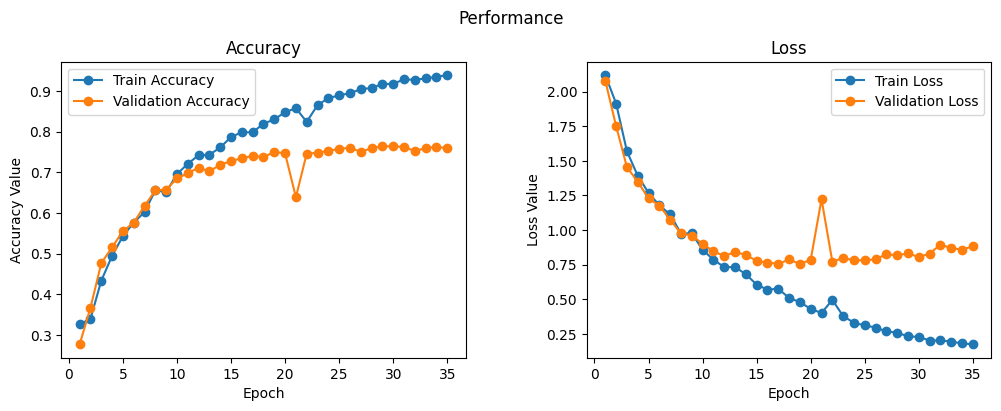

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle('Performance', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, train_acc, label='Train Accuracy', marker='o')
ax1.plot(epoch_list, val_acc, label='Validation Accuracy', marker='o')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, train_loss, label='Train Loss', marker='o')
ax2.plot(epoch_list, val_loss, label='Validation Loss', marker='o')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### Classification Metrics & Confusion Matrix

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

with torch.no_grad():
    y_test = []
    y_pred = []
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = teacher(images)
        _, predicted = torch.max(outputs.data, 1)
        y_test += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

# Generate the classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test,y_pred))
print("Performance Report: \n", classification_report(y_test, y_pred, target_names=classes))

Accuracy: 0.7577
Confusion Matrix: 
 [[819  42  20  15  25  11   9   8  31  20]
 [ 13 892   3   7   0  10   1   6  15  53]
 [ 80   4 666  49  68  37  51  27  11   7]
 [ 20   6  53 602  63 149  46  42  12   7]
 [ 32   2  59  47 726  32  45  42  12   3]
 [ 13   3  42 189  51 625  17  43   5  12]
 [  6  10  40  66  17  38 803   7   8   5]
 [ 20   2  24  38  47  39   4 815   2   9]
 [ 68  41   6  15   7   4   4   3 837  15]
 [ 32  98   7  13   7  13   3  13  22 792]]
Performance Report: 
               precision    recall  f1-score   support

       plane       0.74      0.82      0.78      1000
         car       0.81      0.89      0.85      1000
        bird       0.72      0.67      0.69      1000
         cat       0.58      0.60      0.59      1000
        deer       0.72      0.73      0.72      1000
         dog       0.65      0.62      0.64      1000
        frog       0.82      0.80      0.81      1000
       horse       0.81      0.81      0.81      1000
        ship       0.88

### Save the Model

In [ ]:
# Save the teacher_model
#filename = 'teacher_model.sav'
#pickle.dump(teacher, open(filename, 'wb'))

In [ ]:
torch.save(teacher.state_dict(), 'model_teacher')

In [ ]:
tm = models.densenet121(pretrained=True)
num_ftrs = tm.classifier.in_features
tm.classifier = nn.Linear(num_ftrs, 10)
tm.load_state_dict(torch.load('model_teacher'))
tm.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# Define the class labels (replace with your own class labels)
class_labels = test_dataset.classes

# Function to predict and visualize results
# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test dataset and make predictions
with torch.no_grad():
    for images, labels in testloader:
        outputs = tm(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# Generate classification report
class_names = test_dataset.classes
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

Accuracy: 0.76
              precision    recall  f1-score   support

    airplane       0.74      0.82      0.78      1000
  automobile       0.83      0.90      0.86      1000
        bird       0.73      0.68      0.71      1000
         cat       0.57      0.62      0.59      1000
        deer       0.74      0.72      0.73      1000
         dog       0.66      0.63      0.65      1000
        frog       0.83      0.80      0.82      1000
       horse       0.80      0.82      0.81      1000
        ship       0.90      0.84      0.87      1000
       truck       0.86      0.81      0.83      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.77     10000
weighted avg       0.77      0.76      0.77     10000



## Student Model

### Initializing the model

In [ ]:
# Define the MobileNet architecture
student = models.mobilenet_v2(pretrained=False)
num_ftrs = student.classifier[1].in_features
print ("num_ftrs=", num_ftrs)
student.classifier[1] = nn.Linear(num_ftrs, 10)
student.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


num_ftrs= 1280


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
torchinfo.summary(student, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0)

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
MobileNetV2                                        [1, 3, 224, 224]          [1, 10]                   --                        --                        --
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 1280, 7, 7]           --                        --                        --
│    └─Conv2dNormActivation: 2-1                   [1, 3, 224, 224]          [1, 32, 112, 112]         --                        --                        --
│    │    └─Conv2d: 3-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         864                       [3, 3]                    10,838,016
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         64                        --                        64
│    │    └─ReLU6: 3-3               

### Training the Senior Student model

In [ ]:
# Define the temperature for softening the logits
T = 4

# Define the optimizer for training the MobileNet model
optimizer2 = optim.SGD(student.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [ ]:
epochs2 = 35

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

# Assuming you have defined the 'senior' and 'teacher' models and initialized them

def train_student(senior, teacher, trainloader, valloader, epochs, T, device, optimizer):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(epochs2):
        l1 = []
        l2 = []
        a1 = []
        a2 = []

        for i, (img, labels) in enumerate(trainloader):
            img = img.to(device)
            labels = labels.to(device)
            output = student(img)

            # Accuracy
            probs = F.softmax(output, dim=1)
            max_prob, preds = torch.max(probs, dim=1)
            acc = (torch.sum(preds == labels).item() / len(preds))
            a1.append(acc)

            # Loss
            compare = teacher(img)
            pdist = F.softmax(compare / T, dim=1)
            soft_loss_teacher = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(output / T, dim=1), pdist)
            loss = nn.CrossEntropyLoss()(output, labels)
            loss = 0.4 * loss + 0.6 * soft_loss_teacher
            l1.append(loss.item())

            # Backpropagation
            optimizer2.zero_grad()
            loss.backward()
            optimizer2.step()

        for img, lbl in valloader:
            img = img.to(device)
            lbl = lbl.to(device)
            output = senior(img)
            loss = nn.CrossEntropyLoss()(output, lbl)
            l2.append(loss.item())
            probs = F.softmax(output, dim=1)
            max_prob, preds = torch.max(probs, dim=1)
            acc = (torch.sum(preds == lbl).item() / len(preds))
            a2.append(acc)

        train_loss.append(np.mean(l1))
        val_loss.append(np.mean(l2))
        train_acc.append(np.mean(a1))
        val_acc.append(np.mean(a2))

        print(f'Epoch {epoch+1}: Train Loss==> {np.mean(l1):.2f} Train_Acc==> {np.mean(a1)*100 :.3f} % Val Loss==> {np.mean(l2):.2f}  Val_Acc==> {np.mean(a2)*100 :.3f} %')

    return train_loss, val_loss, train_acc, val_acc

train_loss, val_loss, train_acc, val_acc = train_student(student, teacher, trainloader, valloader, epochs2, T, device, optimizer2)

Epoch 1: Train Loss==> 1.13 Train_Acc==> 30.890 % Val Loss==> 1.76  Val_Acc==> 37.689 %
Epoch 2: Train Loss==> 0.93 Train_Acc==> 43.163 % Val Loss==> 1.53  Val_Acc==> 46.019 %
Epoch 3: Train Loss==> 0.85 Train_Acc==> 48.380 % Val Loss==> 1.45  Val_Acc==> 49.393 %
Epoch 4: Train Loss==> 0.78 Train_Acc==> 52.502 % Val Loss==> 1.37  Val_Acc==> 52.568 %
Epoch 5: Train Loss==> 0.72 Train_Acc==> 56.110 % Val Loss==> 1.29  Val_Acc==> 54.777 %
Epoch 6: Train Loss==> 0.67 Train_Acc==> 58.903 % Val Loss==> 1.25  Val_Acc==> 56.847 %
Epoch 7: Train Loss==> 0.63 Train_Acc==> 61.572 % Val Loss==> 1.22  Val_Acc==> 58.012 %
Epoch 8: Train Loss==> 0.59 Train_Acc==> 63.923 % Val Loss==> 1.19  Val_Acc==> 60.161 %
Epoch 9: Train Loss==> 0.56 Train_Acc==> 65.800 % Val Loss==> 1.14  Val_Acc==> 61.425 %
Epoch 10: Train Loss==> 0.53 Train_Acc==> 67.517 % Val Loss==> 1.11  Val_Acc==> 62.580 %
Epoch 11: Train Loss==> 0.51 Train_Acc==> 69.002 % Val Loss==> 1.09  Val_Acc==> 63.346 %
Epoch 12: Train Loss==> 0.49 T

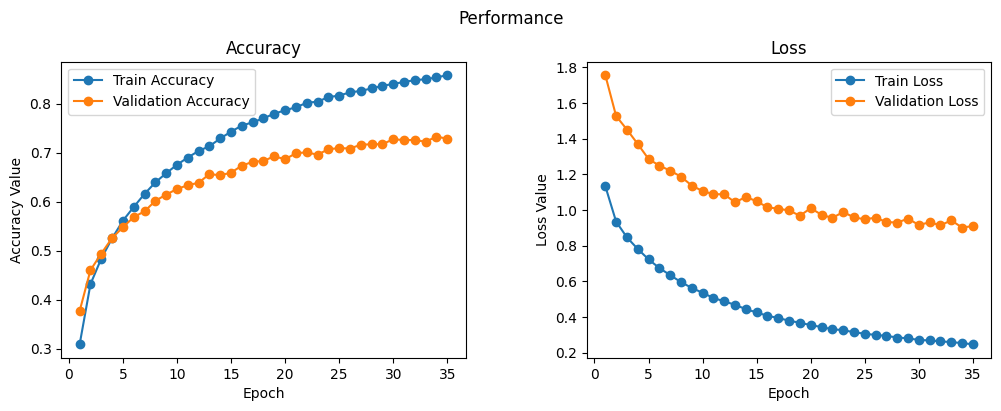

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
title = fig.suptitle('Performance', fontsize=12)
fig.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs2+1))
ax1.plot(epoch_list, train_acc, label='Train Accuracy', marker='o')
ax1.plot(epoch_list, val_acc, label='Validation Accuracy', marker='o')
ax1.set_xticks(np.arange(0, epochs2+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, train_loss, label='Train Loss', marker='o')
ax2.plot(epoch_list, val_loss, label='Validation Loss', marker='o')
ax2.set_xticks(np.arange(0, epochs2+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

with torch.no_grad():
    y_test = []
    y_pred = []
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = student(images)
        _, predicted = torch.max(outputs.data, 1)
        y_test += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

# Generate the classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_test,y_pred))
print("Performance Report: \n", classification_report(y_test, y_pred, target_names=classes))

Accuracy: 0.7285
Confusion Matrix: 
 [[774  27  60  14  14   1   4  12  74  20]
 [ 25 881   7   4   2   5   7   3  19  47]
 [ 62   8 630  69  81  57  52  25  13   3]
 [ 29   8  50 535  62 164  57  50  18  27]
 [ 20   3  71  62 716  27  38  50   8   5]
 [ 15   2  51 173  52 593  29  66   4  15]
 [ 12   8  40  91  35  20 769   4  12   9]
 [ 28   3  24  34  65  38   6 783   2  17]
 [ 58  31  10  17   8   2   5   3 850  16]
 [ 49 113  12   7   9   7   2  22  25 754]]
Performance Report: 
               precision    recall  f1-score   support

       plane       0.72      0.77      0.75      1000
         car       0.81      0.88      0.85      1000
        bird       0.66      0.63      0.64      1000
         cat       0.53      0.54      0.53      1000
        deer       0.69      0.72      0.70      1000
         dog       0.65      0.59      0.62      1000
        frog       0.79      0.77      0.78      1000
       horse       0.77      0.78      0.78      1000
        ship       0.83

In [ ]:
# Save the seniorstudent_model
#filename = 'student_model.sav'
#pickle.dump(student, open(filename, 'wb'))

In [ ]:
torch.save(student.state_dict(), 'model_student')

In [ ]:
sm = models.mobilenet_v2(pretrained=False)
num_ftrs = sm.classifier[1].in_features
sm.classifier[1] = nn.Linear(num_ftrs, 10)
sm.load_state_dict(torch.load('model_student'))
sm.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# Define the class labels (replace with your own class labels)
class_labels = test_dataset.classes

# Function to predict and visualize results
# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test dataset and make predictions
with torch.no_grad():
    for images, labels in testloader:
        outputs = sm(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predicted.tolist())

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# Generate classification report
class_names = test_dataset.classes
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

Accuracy: 0.74
              precision    recall  f1-score   support

    airplane       0.75      0.76      0.75      1000
  automobile       0.81      0.90      0.85      1000
        bird       0.65      0.66      0.65      1000
         cat       0.56      0.54      0.55      1000
        deer       0.67      0.75      0.71      1000
         dog       0.68      0.58      0.63      1000
        frog       0.77      0.80      0.79      1000
       horse       0.79      0.78      0.78      1000
        ship       0.85      0.85      0.85      1000
       truck       0.83      0.77      0.80      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

